In [1]:
'''
Colabl사용시:
!pip install botorch gpytorch
입력하여 botorch 및 gpytorch 가상머신에 설치
'''

'\nColabl사용시:\n!pip install botorch gpytorch\n입력하여 botorch 및 gpytorch 가상머신에 설치\n'

In [75]:
import torch   #벡터(텐서)의 연산 및 미적분을 지원하는 라이브러리
torch.set_default_dtype(torch.float64) #더블 프리시전
torch.set_num_threads(2)#병렬 코어 2개까지만. 큰 문제를 사용할 때는 변경해도 무방
from botorch.models import SingleTaskGP #가우시안 프로세스 회귀 연산
from gpytorch.mlls import ExactMarginalLogLikelihood #내 모델과 데이터의 에러 계산
from botorch.fit import fit_gpytorch_mll #내 모델을 학습시키는 기능
from botorch.acquisition import LogExpectedImprovement # 기대 개선량 계산
from botorch.acquisition import qLogExpectedImprovement # 다중 기대 개선량 계산
from botorch.optim import optimize_acqf #기대개선 함수를 극대화하는 점 탐색
import matplotlib.pyplot as plt #그래프 가시화

import pandas as pd # csv 파일 및 excel 파일 불러오기
'''
colab 사용시, 아래 커맨드 활성화하여 실행.
구글드라이브에 연결하고, 데이터 불러올 파일 위치를 좌측 패널에서 찾아서 경로복사 기능 활용 
'''
#from google.colab import drive
#drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
file_path="/content/drive/MyDrive/예제.xlsx" #파일 경로 설정
df = pd.read_excel(file_path, usecols='B:F',skiprows=[0,1,2,3], header=None) #엑셀 파일에서 B-F열 중 첫 4행 무시하고 읽기
raw_data=df.values # 읽어온 데이터에서 숫자만 추출
df = pd.read_excel(file_path, usecols='B:E',skiprows=[0], nrows=2,header=None) #엑셀 파일에서 B-E열 중 첫 행 무시하고 읽기
bounds=df.values # 읽어온 데이터에서 숫자만 추출

input_data=raw_data[:,0:4] #입력 데이터 분리
score=raw_data[:,4:] #점수 데이터 분리

#numpy 데이터 pytorch로 변환
input_data=torch.from_numpy(input_data)
score=torch.from_numpy(score)
bounds=torch.from_numpy(bounds)

#입출력 설정
X_train=input_data
Y_train=score

#GP 모델 생성 및 학습
model = SingleTaskGP(X_train, Y_train)
mll = ExactMarginalLogLikelihood(model.likelihood, model) #
fit_gpytorch_mll(mll);


#ei = LogExpectedImprovement(model=model, best_f=Y_train.max(), maximize=True) #1조건 추천
ei = qLogExpectedImprovement(model=model, best_f=Y_train.max()) #다조건 동시 추천
candidate, _ = optimize_acqf(
    acq_function=ei,
    bounds=bounds,
    q=5,                 #5개 조건 동시 추천
    num_restarts=5,
    raw_samples=20)

data shape:  (18, 5)
data range:  [[-3.   0.   1.   0.5]
 [ 1.   1.   3.   2. ]]


/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


tensor([[-0.4412,  0.9865,  1.5046,  1.6486],
        [-0.6332,  0.4003,  2.9318,  0.7891],
        [-2.9451,  0.0490,  1.6832,  0.6356],
        [ 1.0000,  0.0000,  2.1962,  0.5000],
        [-2.3103,  0.3711,  2.0185,  1.4226]])


In [86]:
a_test=torch.linspace(-2.,0.9,30) #다른 변수는 고정하고 A만 -2에서 0.9까지 변화
b_test=torch.ones(30)*0.3
c_test=torch.ones(30)*2.
d_test=torch.ones(30)*1.
X_grid=torch.stack((a_test,b_test,c_test,d_test),dim=1) #주어진 조건으로 모델의 예측을 관찰할 그리드 생성


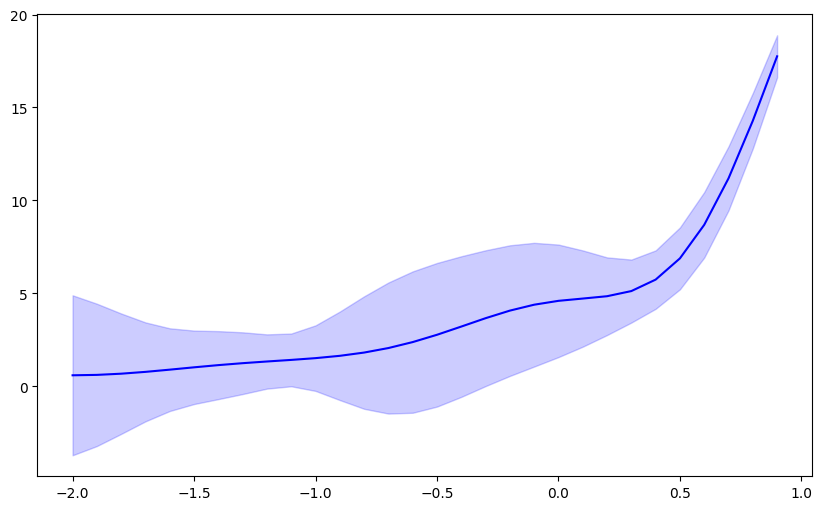

In [87]:
predictions=model.posterior(X_grid) #X_grid에서의 모델의 출력 생성
mean = predictions.mean.detach().numpy() #모델의 예측의 평균값 계산하여 numpy 배열로 변경 (미분 연산 관계식 제거)
lower, upper = predictions.mvn.confidence_region() #모델의 예측의 신뢰구간 생성
plt.figure(figsize=(10, 6)) #그림 크기 지정
plt.plot(a_test.numpy(), mean, label="Predicted Mean", color="blue") #평균값 파란 실선
plt.fill_between(
    a_test.numpy(),
    lower.detach().numpy(),
    upper.detach().numpy(),
    alpha=0.2,
    label="95% Confidence Interval",
    color="blue"
)  #신뢰구간 색칠
